<a href="https://colab.research.google.com/github/brunofernandez-blip/TFG/blob/main/MCMC(NB)_Opinions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kinetic Modelling of Opinion Dynamics (Nanbu-Babovsky Scheme)

This notebook implements a kinetic model of opinion formation based on the **During model**. The system consists of a population of $N$ agents exchanging opinions through binary interactions.

## 1. The Microscopic Model
Each agent possesses an opinion $v \in [-1, 1]$. When two agents $i$ and $j$ interact, their opinions are updated according to the following rules:

$$
v_i^* = v_i - \gamma P(|v_i - v_j|) (v_i - v_j) + \eta_1 D(v_i)
$$
$$
v_j^* = v_j - \gamma P(|v_i - v_j|) (v_j - v_i) + \eta_2 D(v_j)
$$

Where:
* **$\gamma$ (Gamma):** The compromise parameter ($0 < \gamma < 0.5$). Determines how much agents move toward each other.
* **$P(\cdot)$:** The **Bounded Confidence** function. It is an indicator function that returns 1 if the distance $|v_i - v_j| \le r$, and 0 otherwise. This means agents only interact if their opinions are sufficiently close.
* **$\eta$ (Eta):** Noise representing stochastic fluctuations or "self-thinking," sampled from $N(0, \sigma^2)$.
* **$D(v)$:** A diffusion function, in our model: $(1-v^2)^\alpha$, which ensures opinions remain bounded and vanish at the extremes $\pm 1$.

## 2. Numerical Implementation
We solve the Boltzmann-type equation for opinions using a **Direct Simulation Monte Carlo (DSMC)** method, specifically the **Nanbu-Babovsky scheme**.

* **Time Discretization:** The simulation advances in steps of $\Delta t$.
* **Pairing:** At each step, the $N$ agents are randomly shuffled and grouped into $N/2$ pairs.
* **Interaction:** Each pair interacts according to the microscopic rules defined above.
* **Boundary Conditions:** A projection operator (clipping) is applied to ensure no agent exceeds the domain $[-1, 1]$.

## 3. Experiments
The code below simulates the system for varying **Confidence Radii or Bounded Confidence ($r$)** to observe:
1.  **Fragmentation:** (Small $r$) Multiple isolated clusters.
2.  **Polarization:** (Medium $r$) Two opposing groups.
3.  **Consensus:** (Large $r$) Convergence to a single opinion.

We test this against **Uniform**, **Normal**, and **Bimodal** initial distributions.

Running simulation for distribution: uniform...


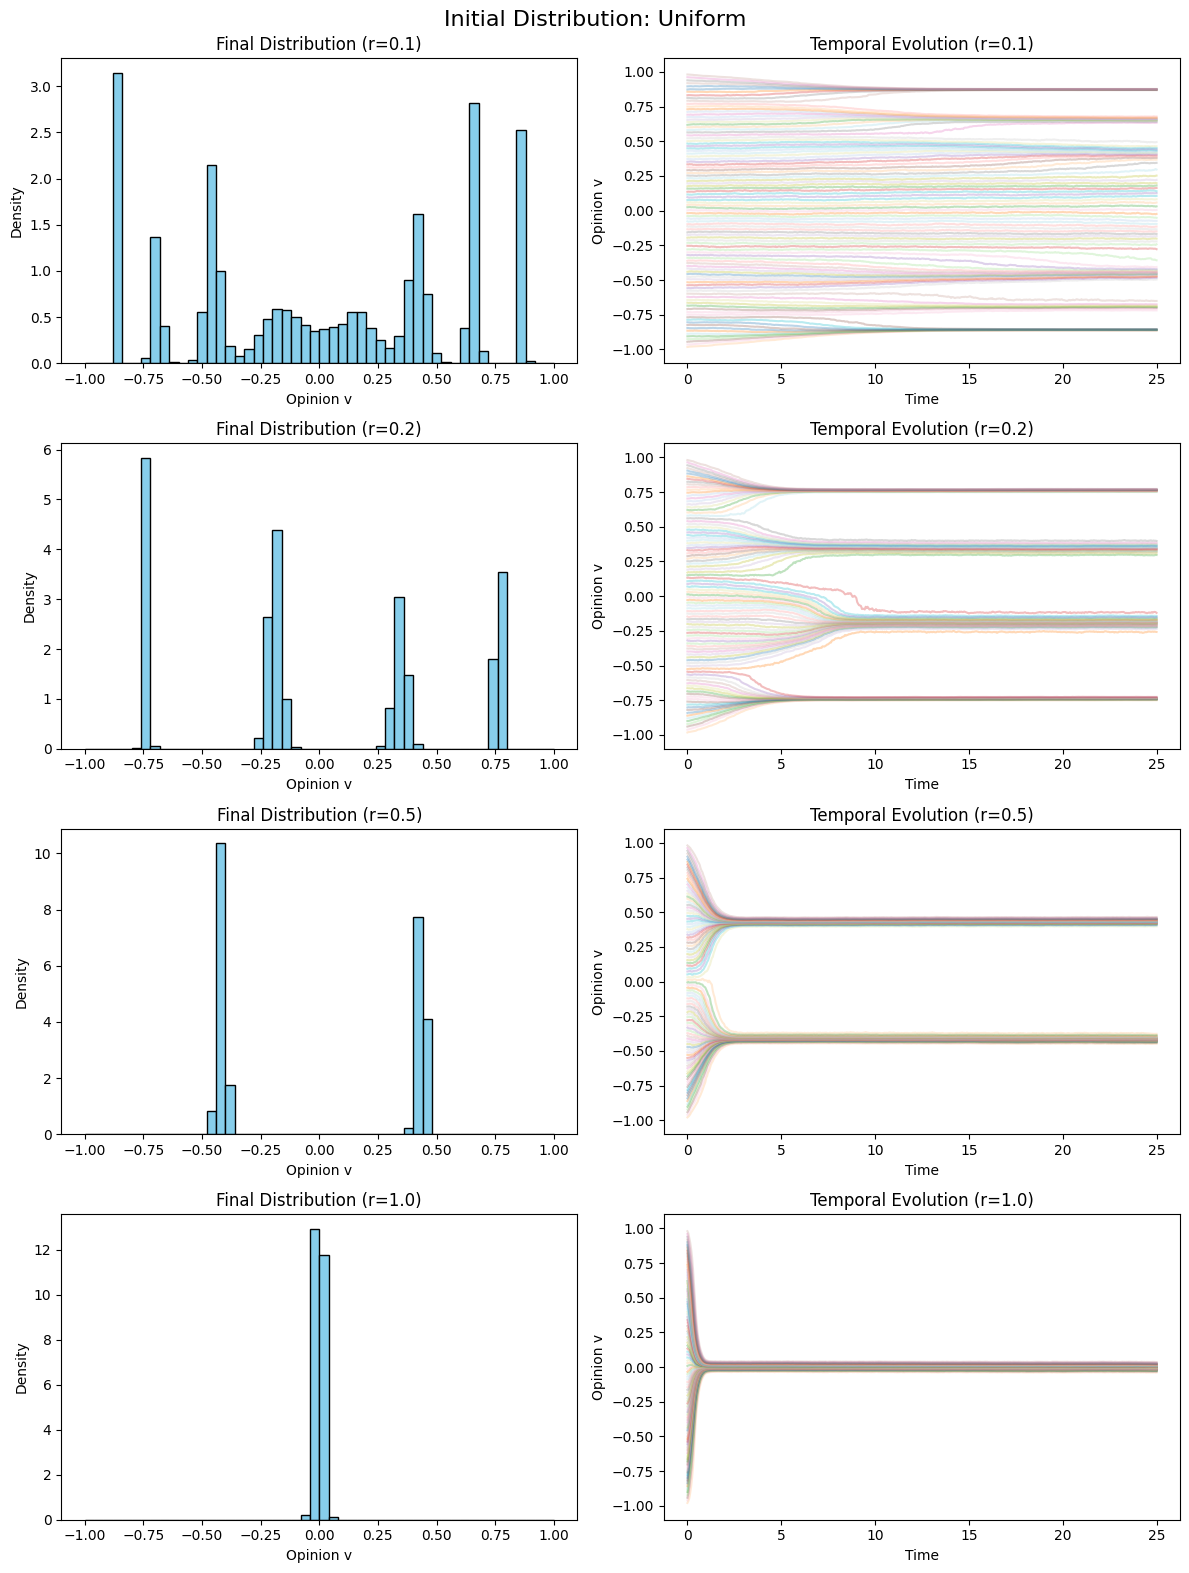

Running simulation for distribution: normal...


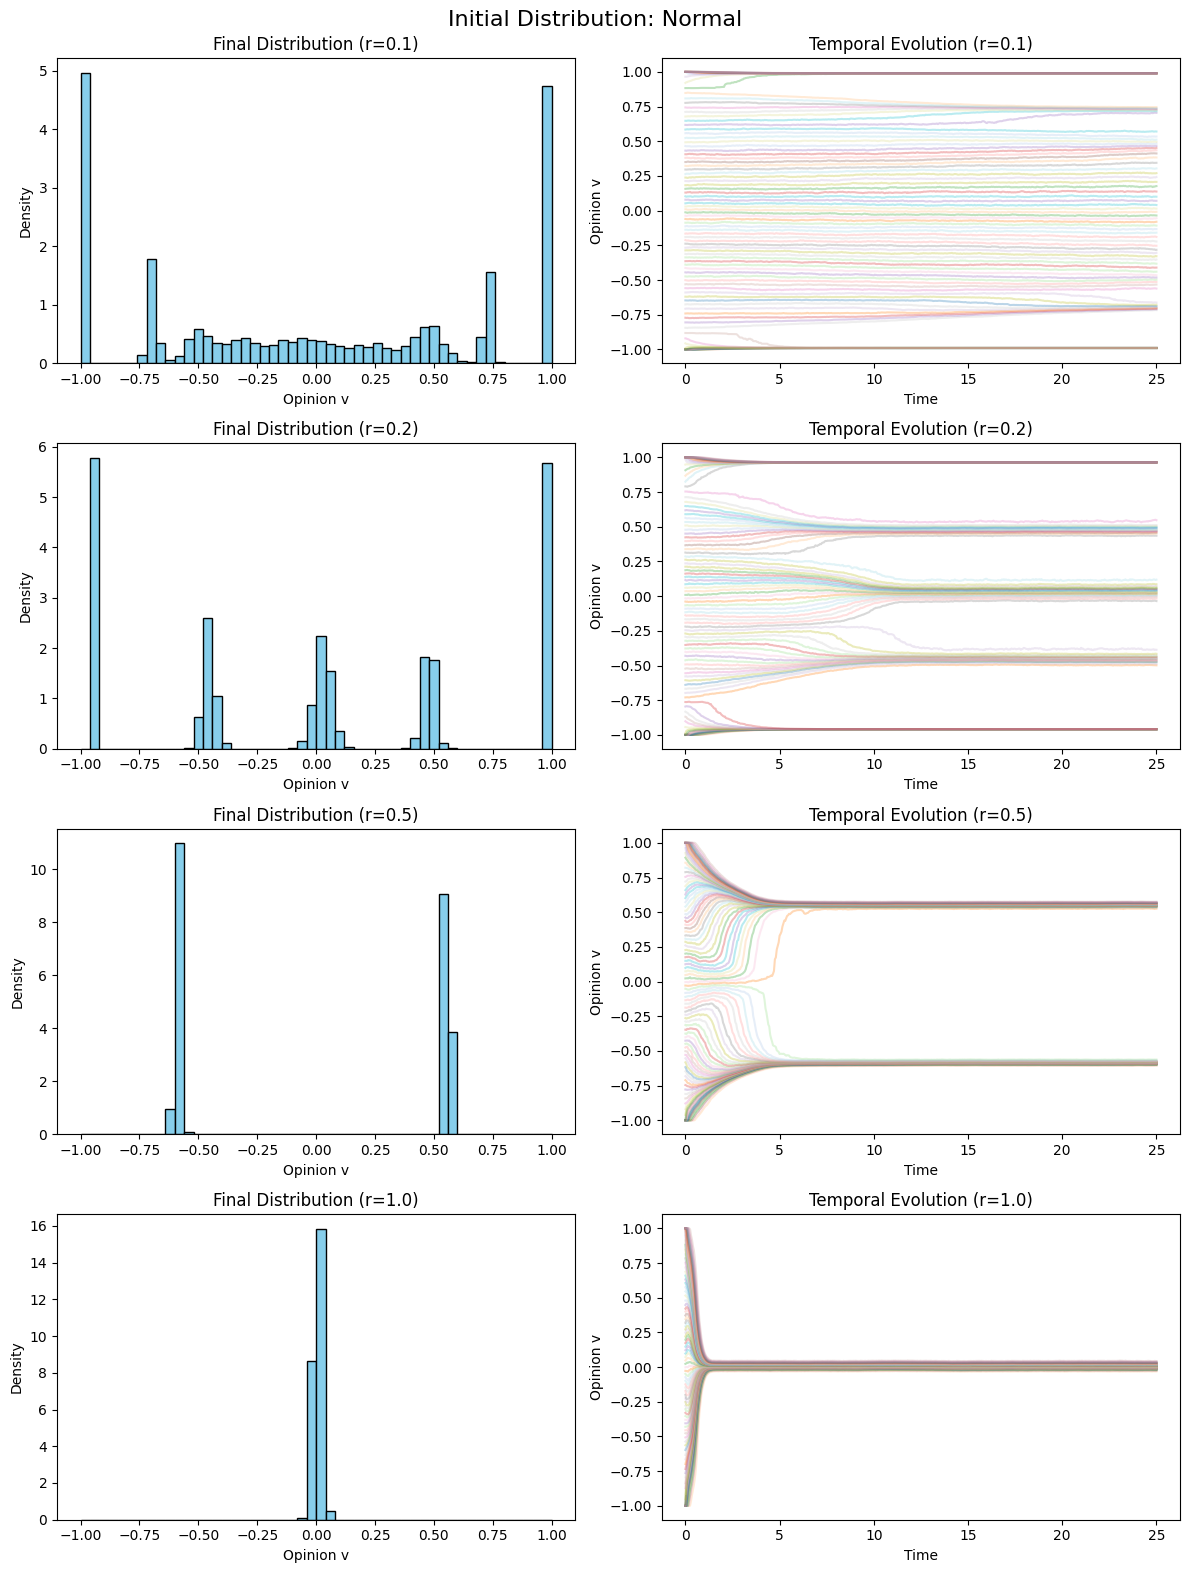

Running simulation for distribution: bimodal...


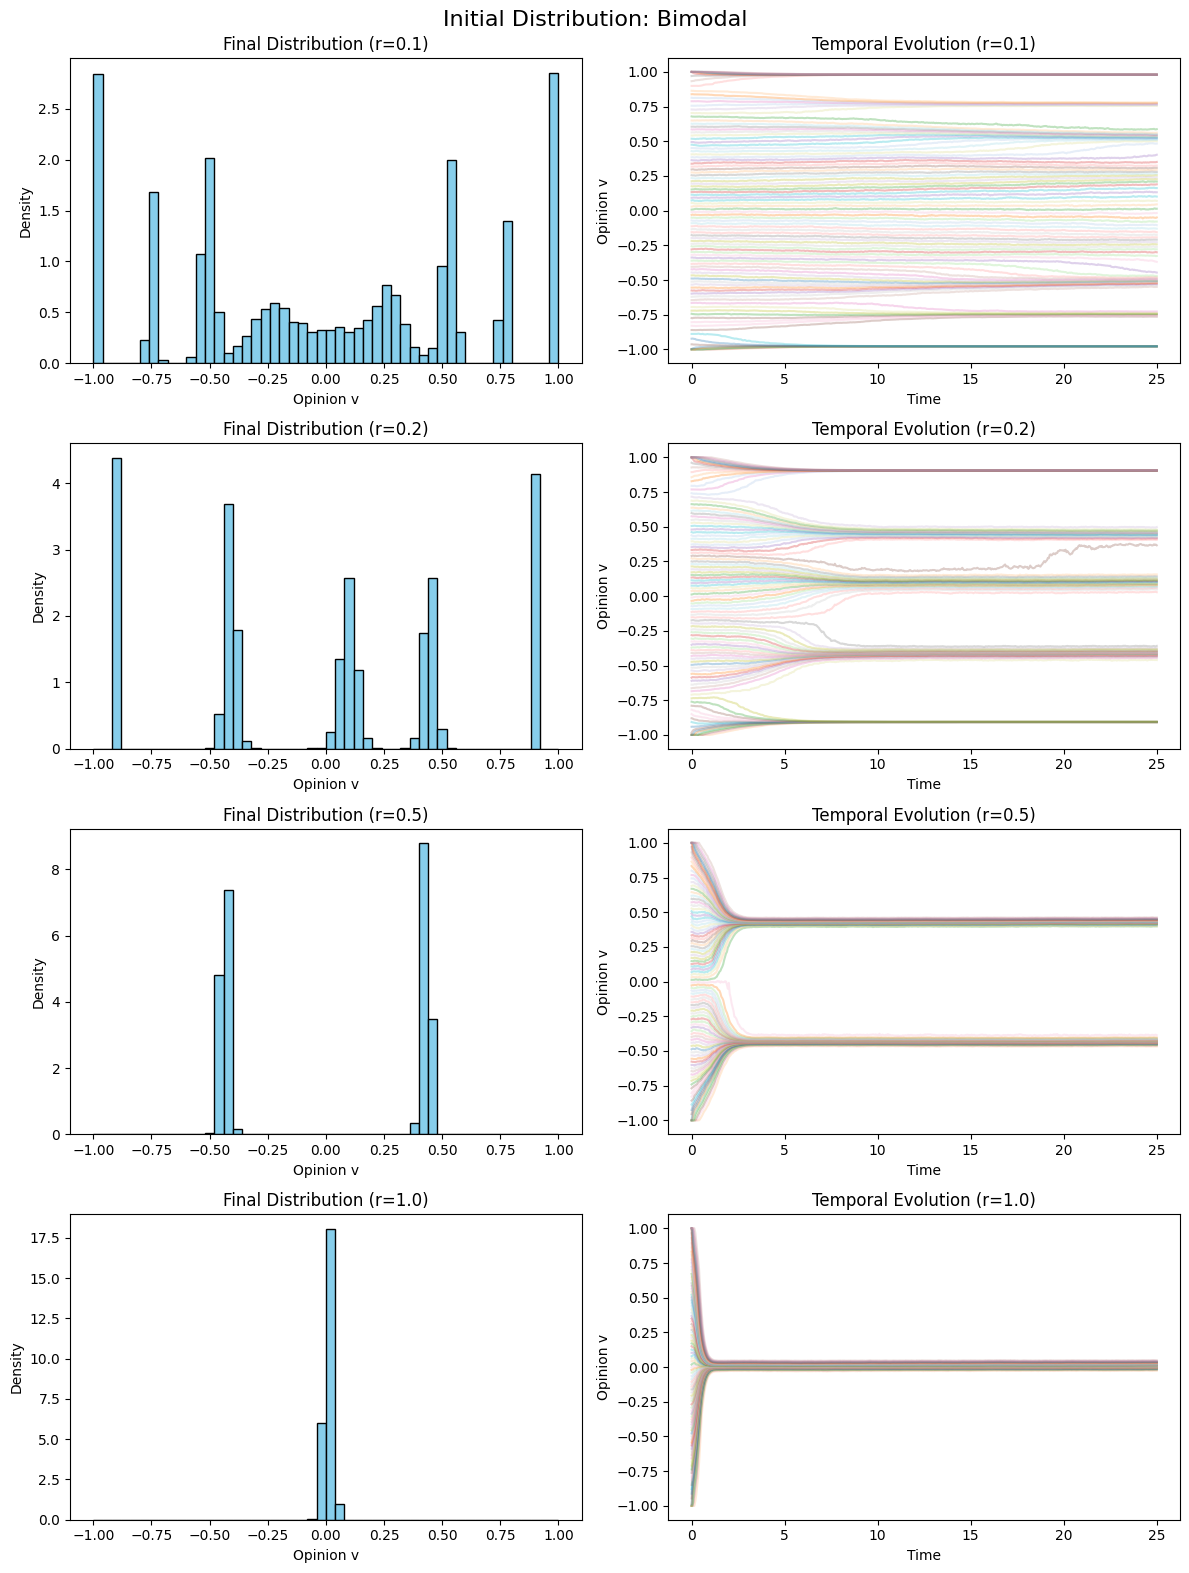

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
N = 10000          # Number of agents
T_final = 25.0    # Total duration of the simulation
dt = 0.05          # Time step
n_steps = int(T_final / dt)

# Social/Physical parameters
gamma = 0.25      # Compromise parameter (we set 0.25, as the value has to be between 0 and 0.5)
sigma = 0.01      # Standard deviation of noise (eta)
alphav = 2.0       # Exponent for the diffusion function D(v) = (1-v^2)^alpha
r_tolerance = 0.5 # Confidence radius

# Auxiliar Functions

def P(dist, r):
    """
    Bounded Confidence Function (Indicator Function)
    Returns 1.0 if the distance between opinions is <= r, else 0.0.
    """
    return np.where(dist <= r, 1.0, 0.0)

def D(v, alpha):
    """
    Diffusion function
    It makes changes near the boundaries more difficult
    """
    return (1 - v**2)**alpha

def simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist):
    """
    Runs the Direct Simulation Monte Carlo (Nanbu-Babovsky scheme).
    """
    # Initialize
    if init_dist == 'uniform':
      # Uniform distribution between -1 and 1
        v = np.random.uniform(-1, 1.000001, N)
        v = np.clip(v, -1, 1)
    elif init_dist == 'normal':
      # Standard normal distribution
        v = np.random.normal(0,1,N)
        v = np.clip(v, -1, 1)
    elif init_dist == 'bimodal':
      # Mixture of two Gaussians centered at -0.5 and 0.5
        v = np.concatenate([
            np.random.normal(-0.5, 0.5, N//2),
            np.random.normal(0.5, 0.5, N//2)
        ])
        v = np.clip(v, -1, 1)

    # Array to save opinions at every time step
    history = np.zeros((n_steps+1, N))
    history[0] = v

    # Time loop
    for t in range(n_steps):
        # NB scheme.
        # Select N/2 random pairs.
        # We assume that for every time step, N/2 pairs are sampled.

        idx = np.random.permutation(N)
        i_idx = idx[:N//2]
        j_idx = idx[N//2:]

        vi = v[i_idx]
        vj = v[j_idx]

        # Opinion distance
        dist = np.abs(vi - vj)

        # Sampling noise (eta)
        # eta ~ Normal(0, sigma)
        eta1 = np.random.normal(0, sigma, size=N//2)
        eta2 = np.random.normal(0, sigma, size=N//2)

        # Compute P
        # P_val will be 1 if both agents interact, 0 otherwise
        P_val = P(dist, r)


        diff = vi - vj

        # Opinions update
        vi_new = vi - gamma * P_val * diff + eta1 * D(vi, alphav)
        vj_new = vj - gamma * P_val * (-diff) + eta2 * D(vj, alphav)

        # Projection operator (or 'clipping') in order to mantain opinions in [-1, 1]
        vi_new = np.clip(vi_new, -1, 1)
        vj_new = np.clip(vj_new, -1, 1)

        # Update opinions vector
        v[i_idx] = vi_new
        v[j_idx] = vj_new

        # Save opinion
        history[t+1] = v

    return history



# Definition of experimental settings
distributions = ['uniform', 'normal', 'bimodal']
radii = [0.1, 0.2, 0.5, 1.0]
time_axis = np.linspace(0, T_final, n_steps + 1)


# 100 lines, representing percentiles from 1% to 99%
# This visualizes the density flow rather than individual agent trajectories
quantiles = np.linspace(1, 99, 100)

# Create a color map for the quantile lines
cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5
np.random.seed(42)
np.random.shuffle(colors)

# Loop for each distribution type
for dist_name in distributions:
    print(f"Running simulation for distribution: {dist_name}...")

    fig, axes = plt.subplots(len(radii), 2, figsize=(12, 4 * len(radii)))

    #Loop for each value of 'r'
    for i, r in enumerate(radii):
        # Run simulation
        history = simulation_opinion(N, n_steps, dt, gamma, sigma, r, alphav, init_dist=dist_name)
        final_opinions = history[-1]

        # Left Column: Final Histogram
        axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True, color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f"Final Distribution (r={r})")
        axes[i, 0].set_xlabel("Opinion v")
        axes[i, 0].set_ylabel("Density")
        axes[i, 0].set_xlim(-1.1, 1.1)

        # Right Column: Temporal Evolution (Quantiles)
        # We plot percentiles over time to visualize how the distribution splits or converges
        quantile_history = np.percentile(history, quantiles, axis=1)

        for q_idx in range(len(quantiles)):
            axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                            color=colors[q_idx], alpha=0.3, linewidth=1.5)

        axes[i, 1].set_title(f"Temporal Evolution (r={r})")
        axes[i, 1].set_xlabel("Time")
        axes[i, 1].set_ylabel("Opinion v")
        axes[i, 1].set_ylim(-1.1, 1.1)

    fig.suptitle(f"Initial Distribution: {dist_name.capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Save figure
    plt.savefig(f"Opinions_r_{dist_name}.png", dpi=150)
    plt.show()


In this second experiment, we analyze the impact of the ** noise parameter $\sigma$**. Sociologically, this term represents external influences, uncertainty in communication, or the degree of self-thinking. In this case, we fix the radius to $r = 0.8$, in order to see how noise affects a fragmented society.

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2364405453.py:35: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
/tmp/ipython-input-2364405453.py:48: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
/tmp/ipython-input-2364405453.py:53: SyntaxWarning: invalid escape sequence '\s'
  fig.suptitle(f"Effect of Noise ($\sigma$) - Initial Dist: {dist_name.capitalize()}", fontsize=16)


Running noise experiment for distribution: uniform...
Saved figure: Opinions_s_uniform_08.png


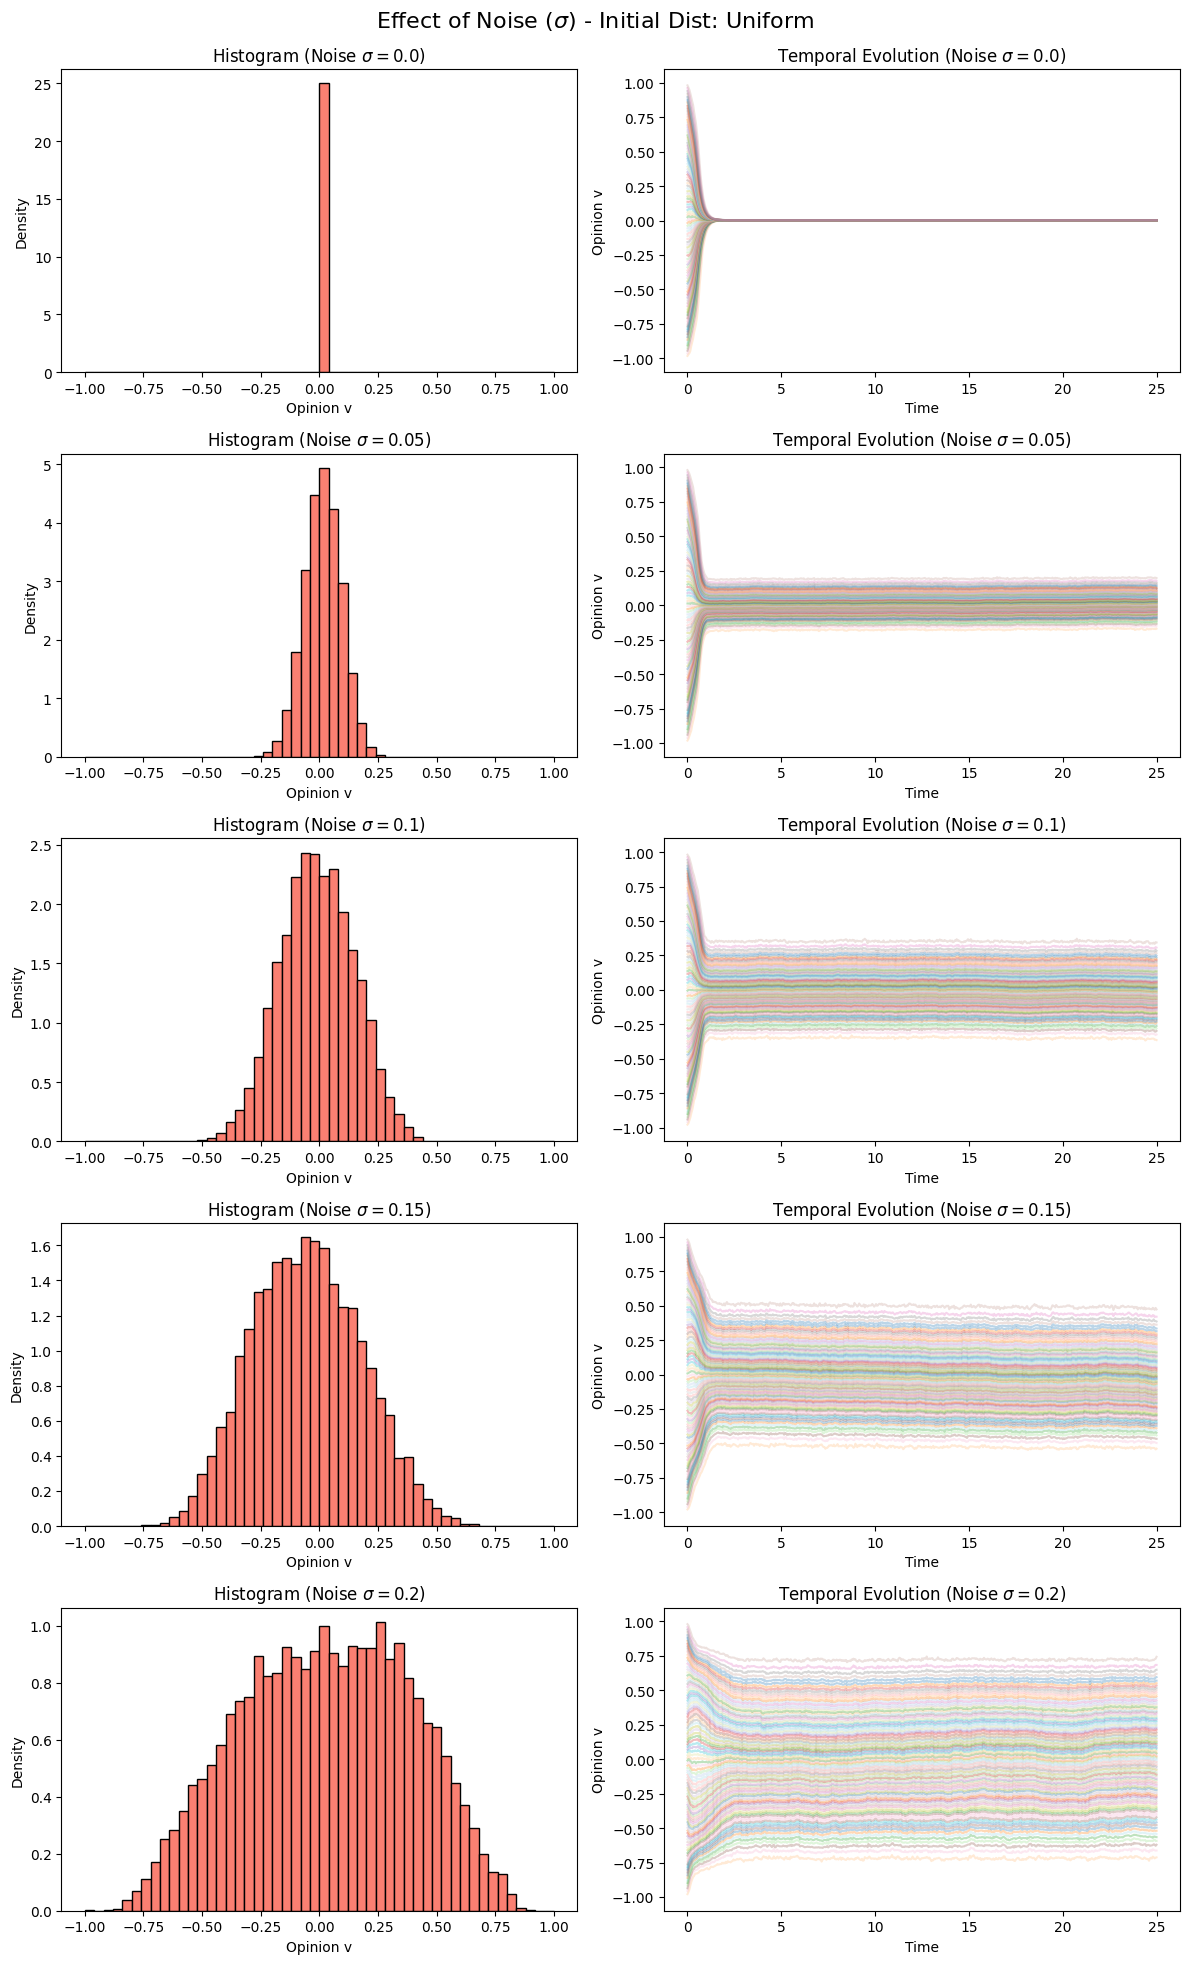

Running noise experiment for distribution: normal...
Saved figure: Opinions_s_normal_08.png


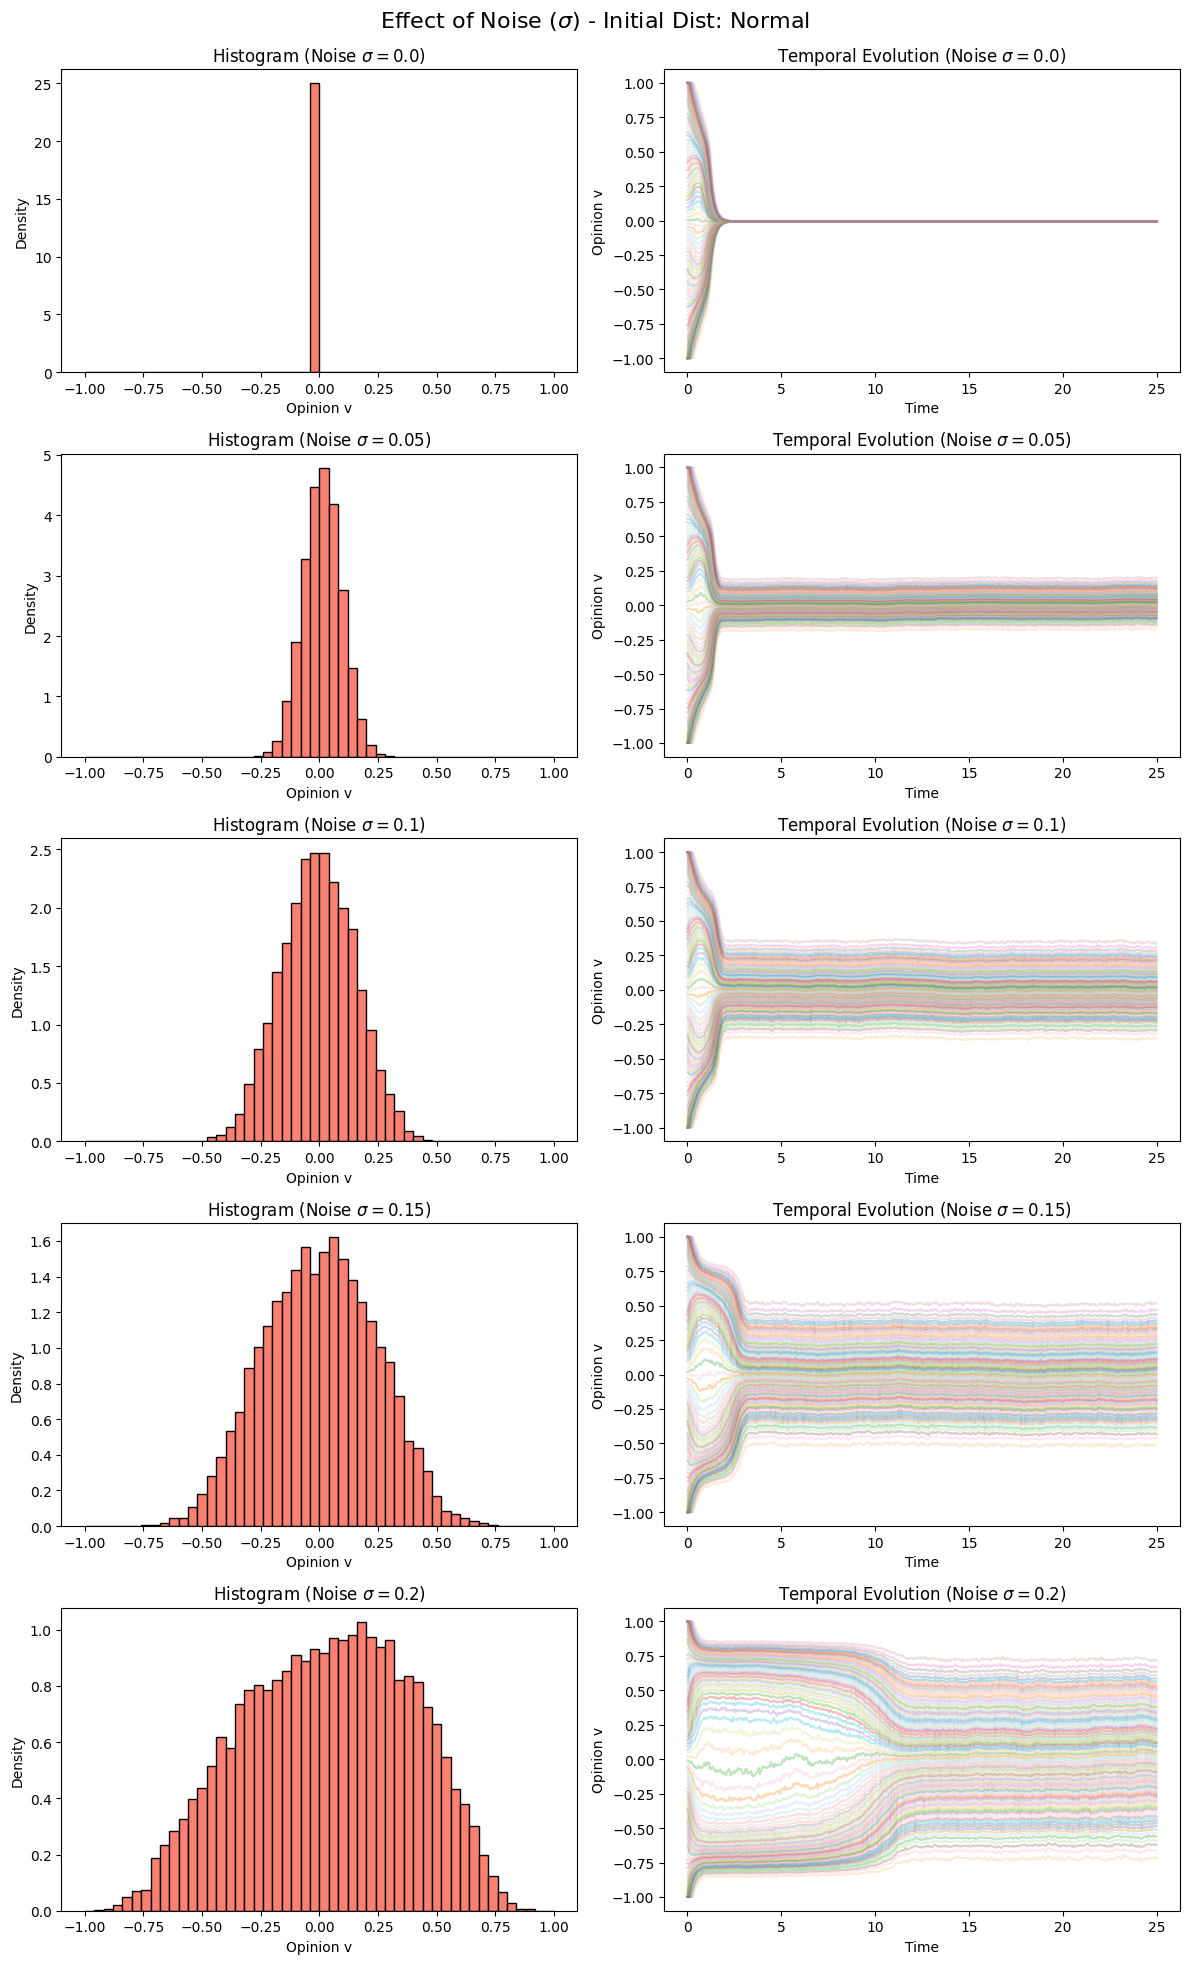

Running noise experiment for distribution: bimodal...
Saved figure: Opinions_s_bimodal_08.png


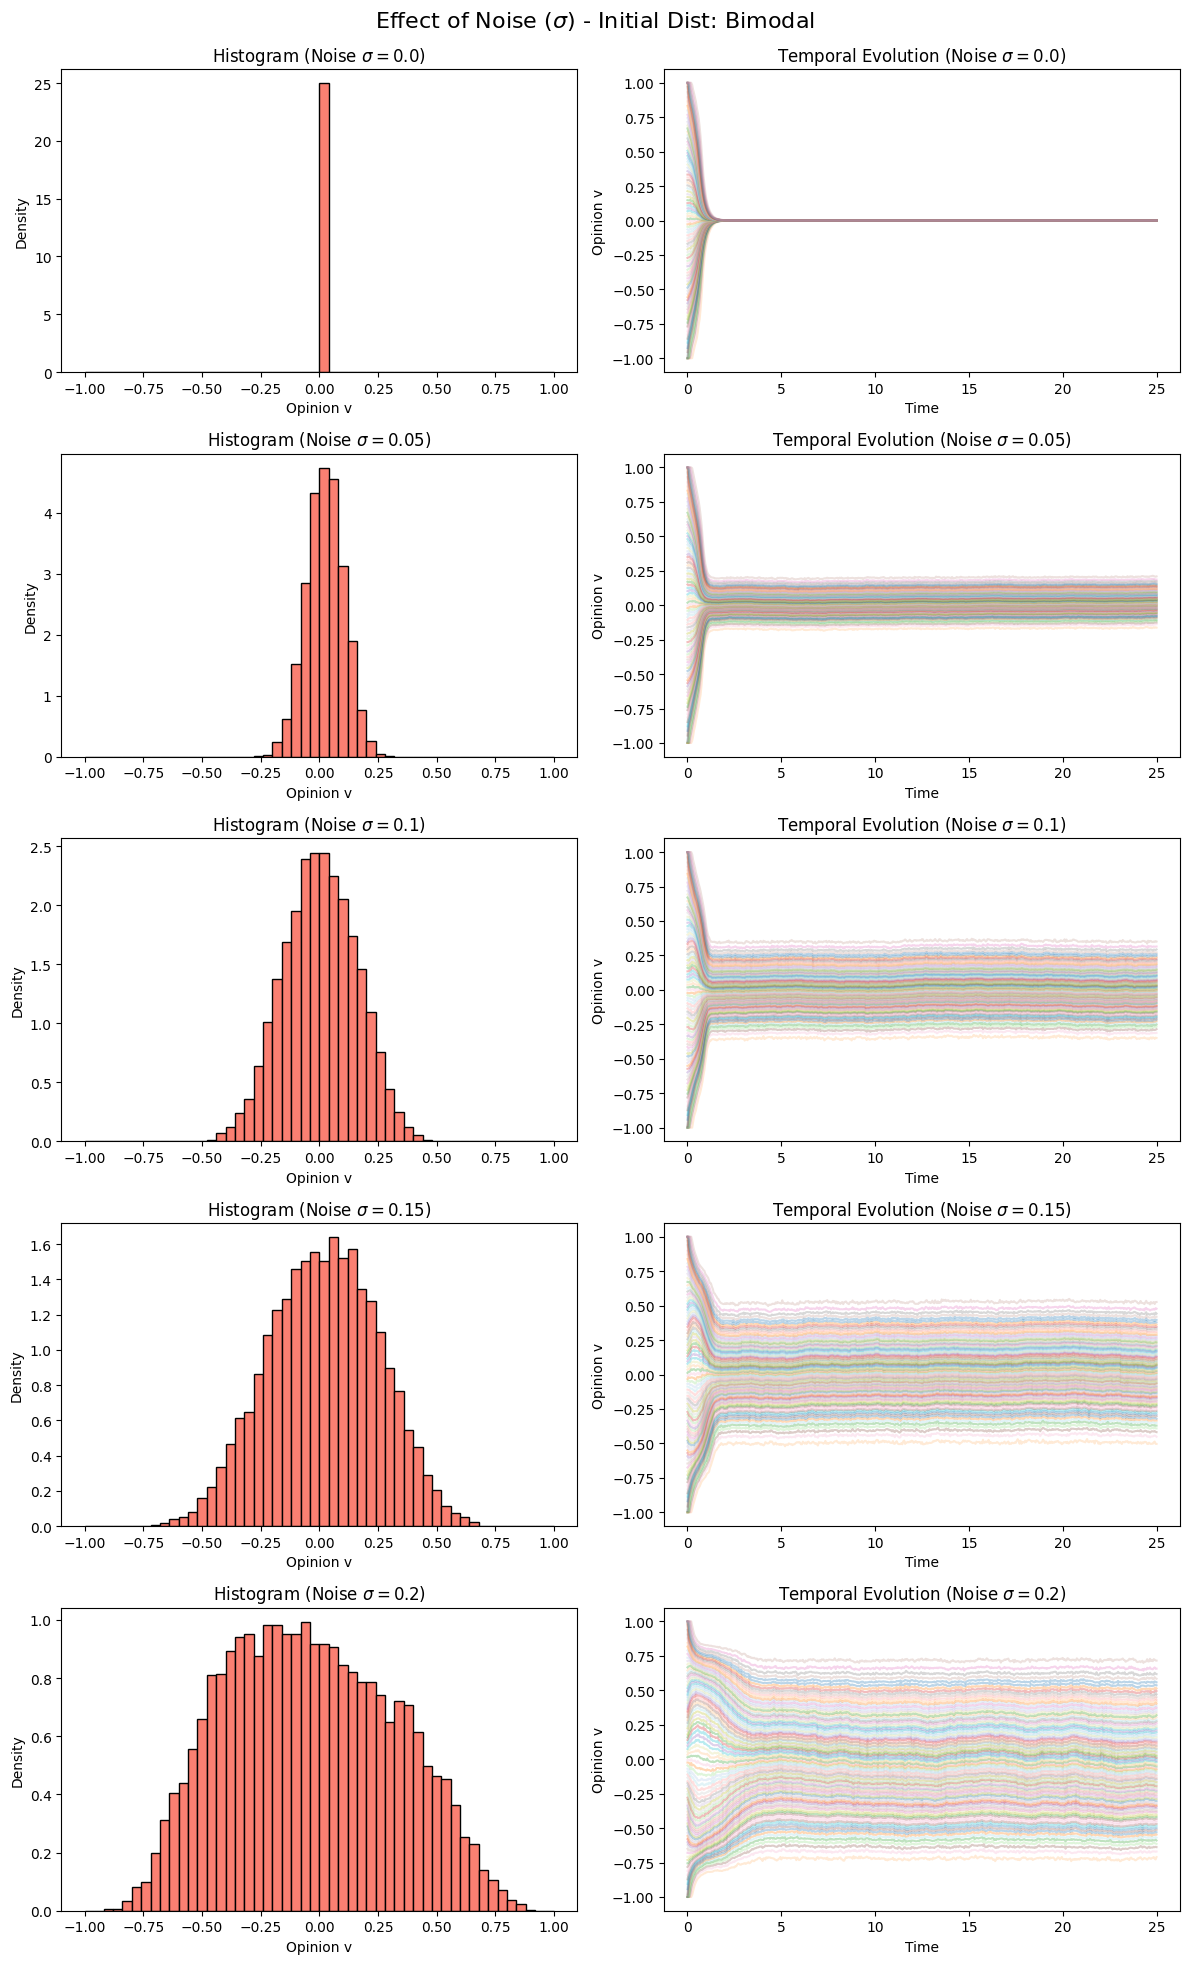

In [7]:
# Second experiment: Varying noise (Diffusion)

# Experimental settings
distributions = ['uniform', 'normal', 'bimodal']
sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.8 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)


# 100 lines, representing percentiles from 1% to 99%
# This visualizes the density flow rather than individual agent trajectories
quantiles = np.linspace(1, 99, 100)

# Create a color map for the quantile lines
cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5
np.random.seed(42)
np.random.shuffle(colors)


# Loop for each distribution
for dist_name in distributions:
    print(f"Running noise experiment for distribution: {dist_name}...")

    fig, axes = plt.subplots(len(sigmas), 2, figsize=(12, 4 * len(sigmas)))

    for i, s in enumerate(sigmas):
        # Run simulation with varying sigma 's' and fixed 'r'
        history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist=dist_name)
        final_opinions = history[-1]

        # Left Column: Final Histogram
        axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True, color='salmon', edgecolor='black')
        axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
        axes[i, 0].set_xlabel("Opinion v")
        axes[i, 0].set_ylabel("Density")
        axes[i, 0].set_xlim(-1.1, 1.1)

        # Right Column: Temporal Evolution (Quantiles)
        # We plot percentiles over time to visualize how the distribution splits or converges
        quantile_history = np.percentile(history, quantiles, axis=1)

        for q_idx in range(len(quantiles)):
            axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                            color=colors[q_idx], alpha=0.3, linewidth=1.5)

        axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
        axes[i, 1].set_xlabel("Time")
        axes[i, 1].set_ylabel("Opinion v")
        axes[i, 1].set_ylim(-1.1, 1.1)

    fig.suptitle(f"Effect of Noise ($\sigma$) - Initial Dist: {dist_name.capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Save figure
    filename = f"Opinions_s_{dist_name}_08.png"
    plt.savefig(filename, dpi=150)
    print(f"Saved figure: {filename}")
    plt.show()


In this second experiment, we analyze the impact of the ** noise parameter $\sigma$**. Sociologically, this term represents external influences, uncertainty in communication, or the degree of self-thinking. In this case, we fix the radius to $r = 0.1$, in order to see how noise affects a fragmented society.

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2077130547.py:35: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
/tmp/ipython-input-2077130547.py:48: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
/tmp/ipython-input-2077130547.py:53: SyntaxWarning: invalid escape sequence '\s'
  fig.suptitle(f"Effect of Noise ($\sigma$) - Initial Dist: {dist_name.capitalize()}", fontsize=16)


Running noise experiment for distribution: uniform...
Saved figure: Opinions_s_uniform_04.png


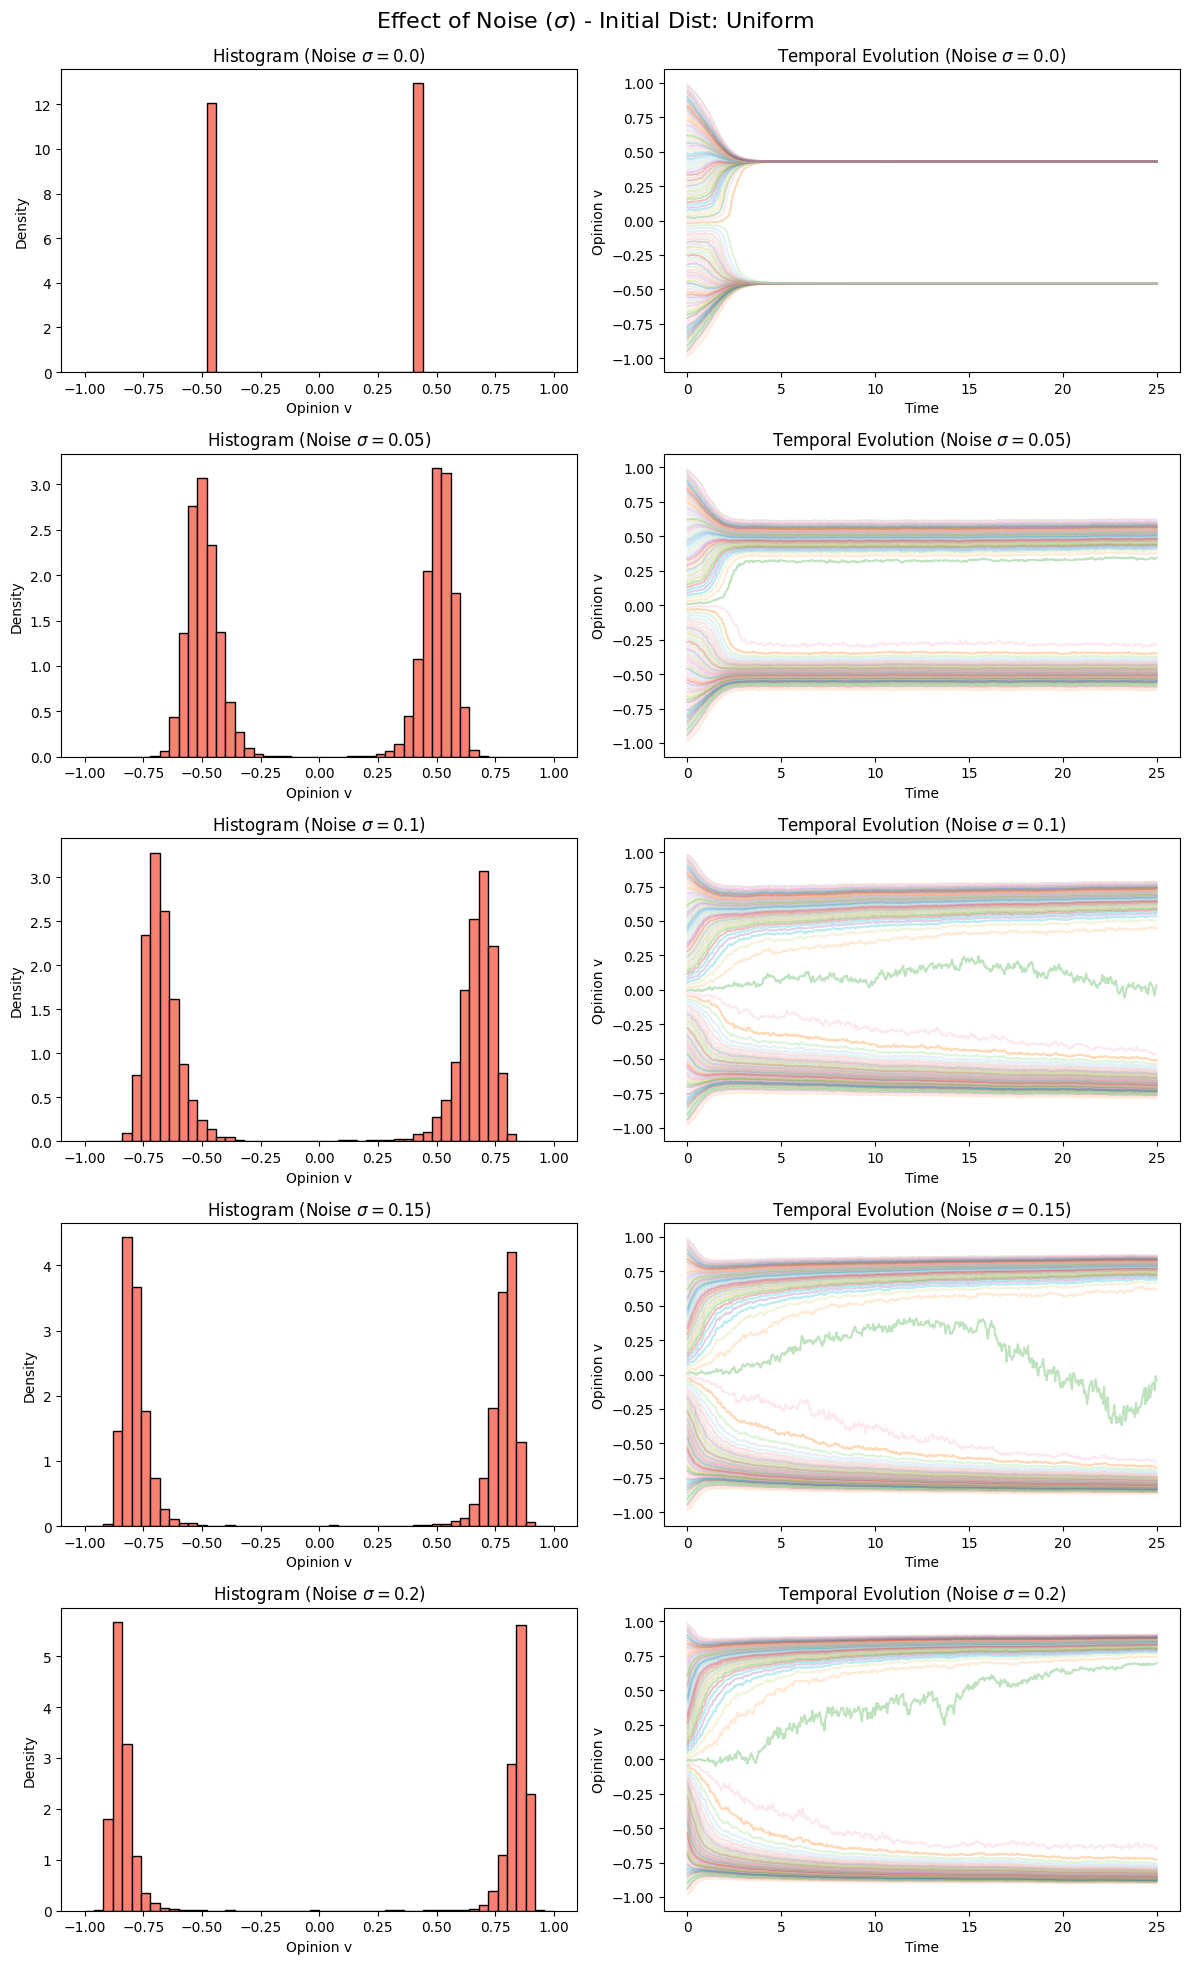

Running noise experiment for distribution: normal...
Saved figure: Opinions_s_normal_04.png


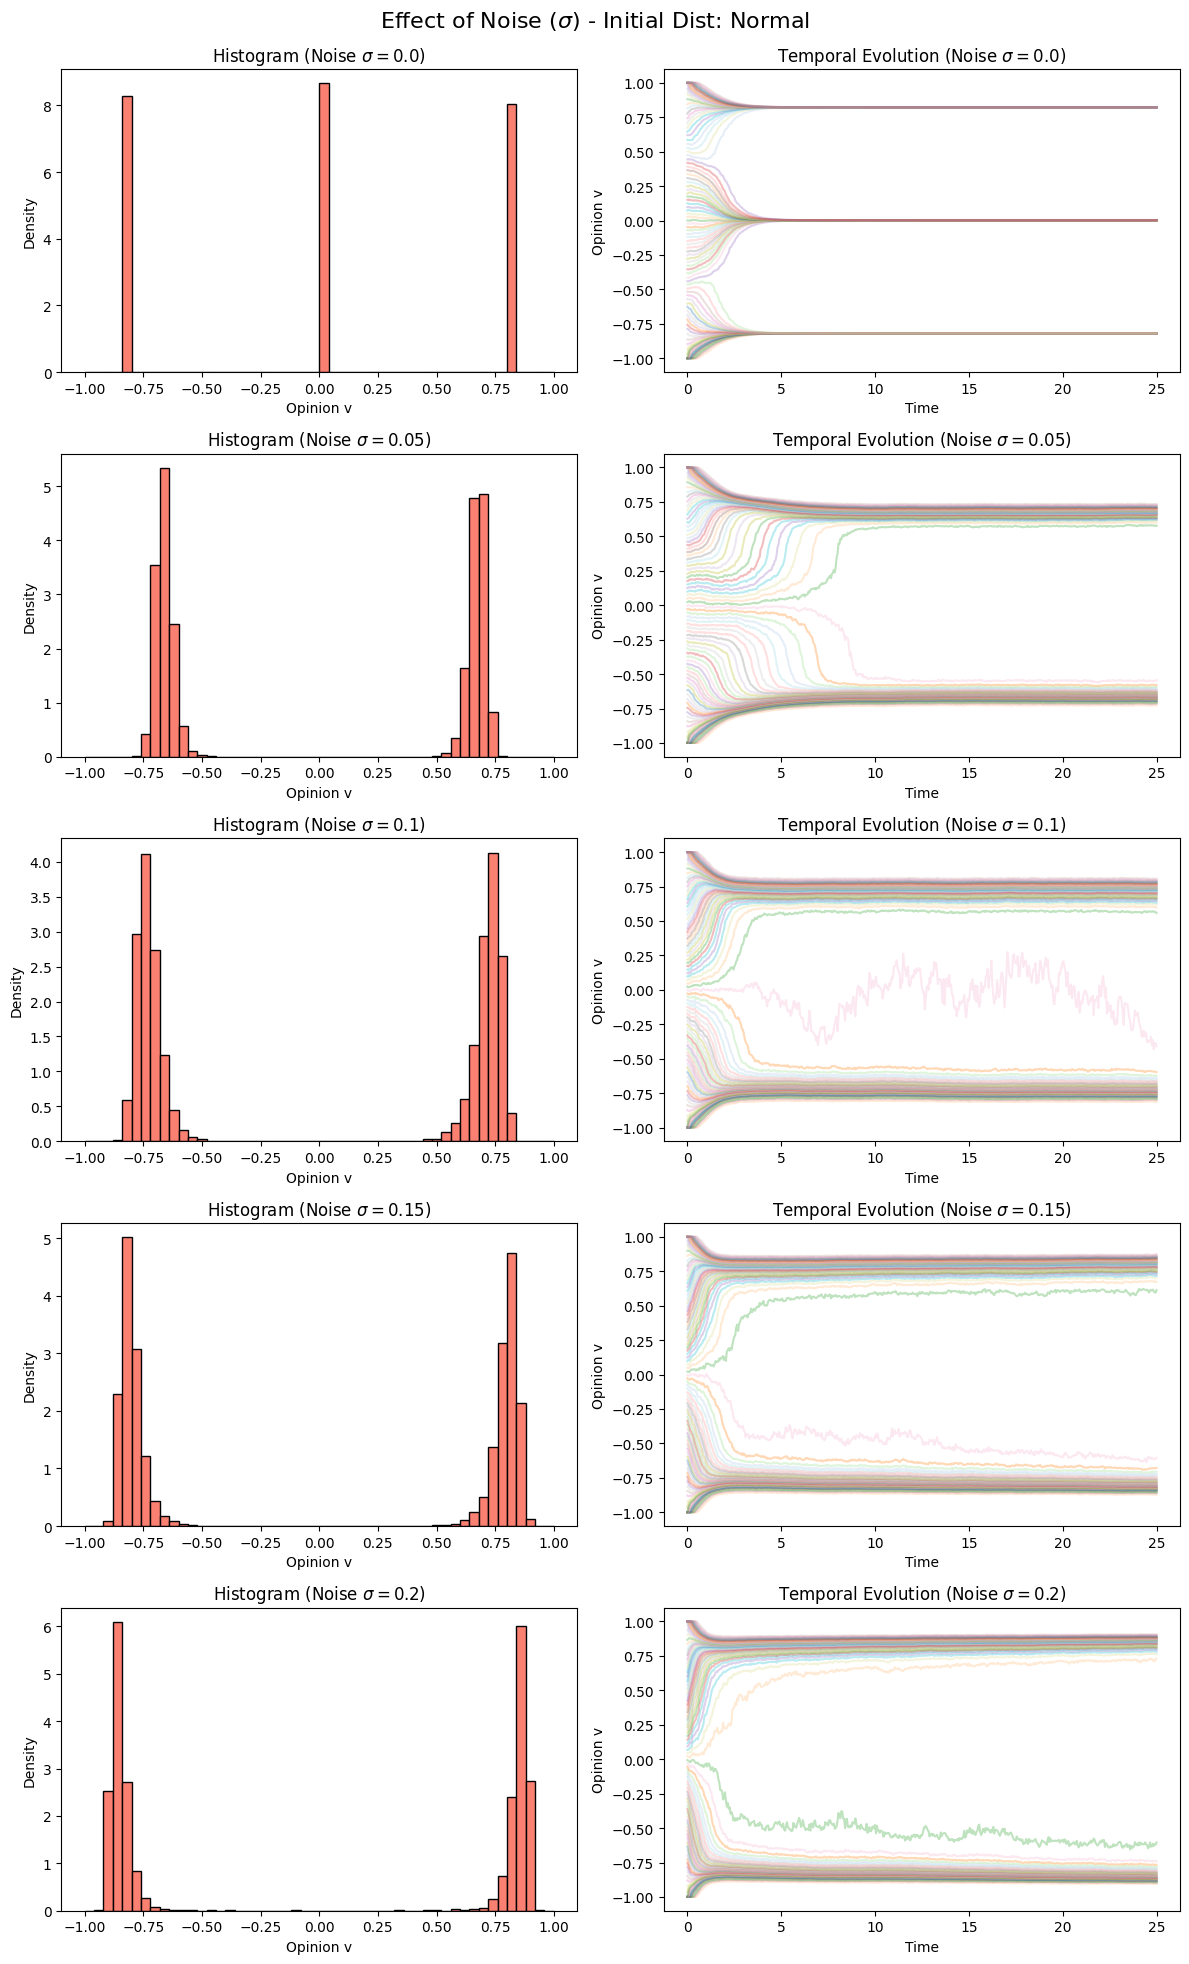

Running noise experiment for distribution: bimodal...
Saved figure: Opinions_s_bimodal_04.png


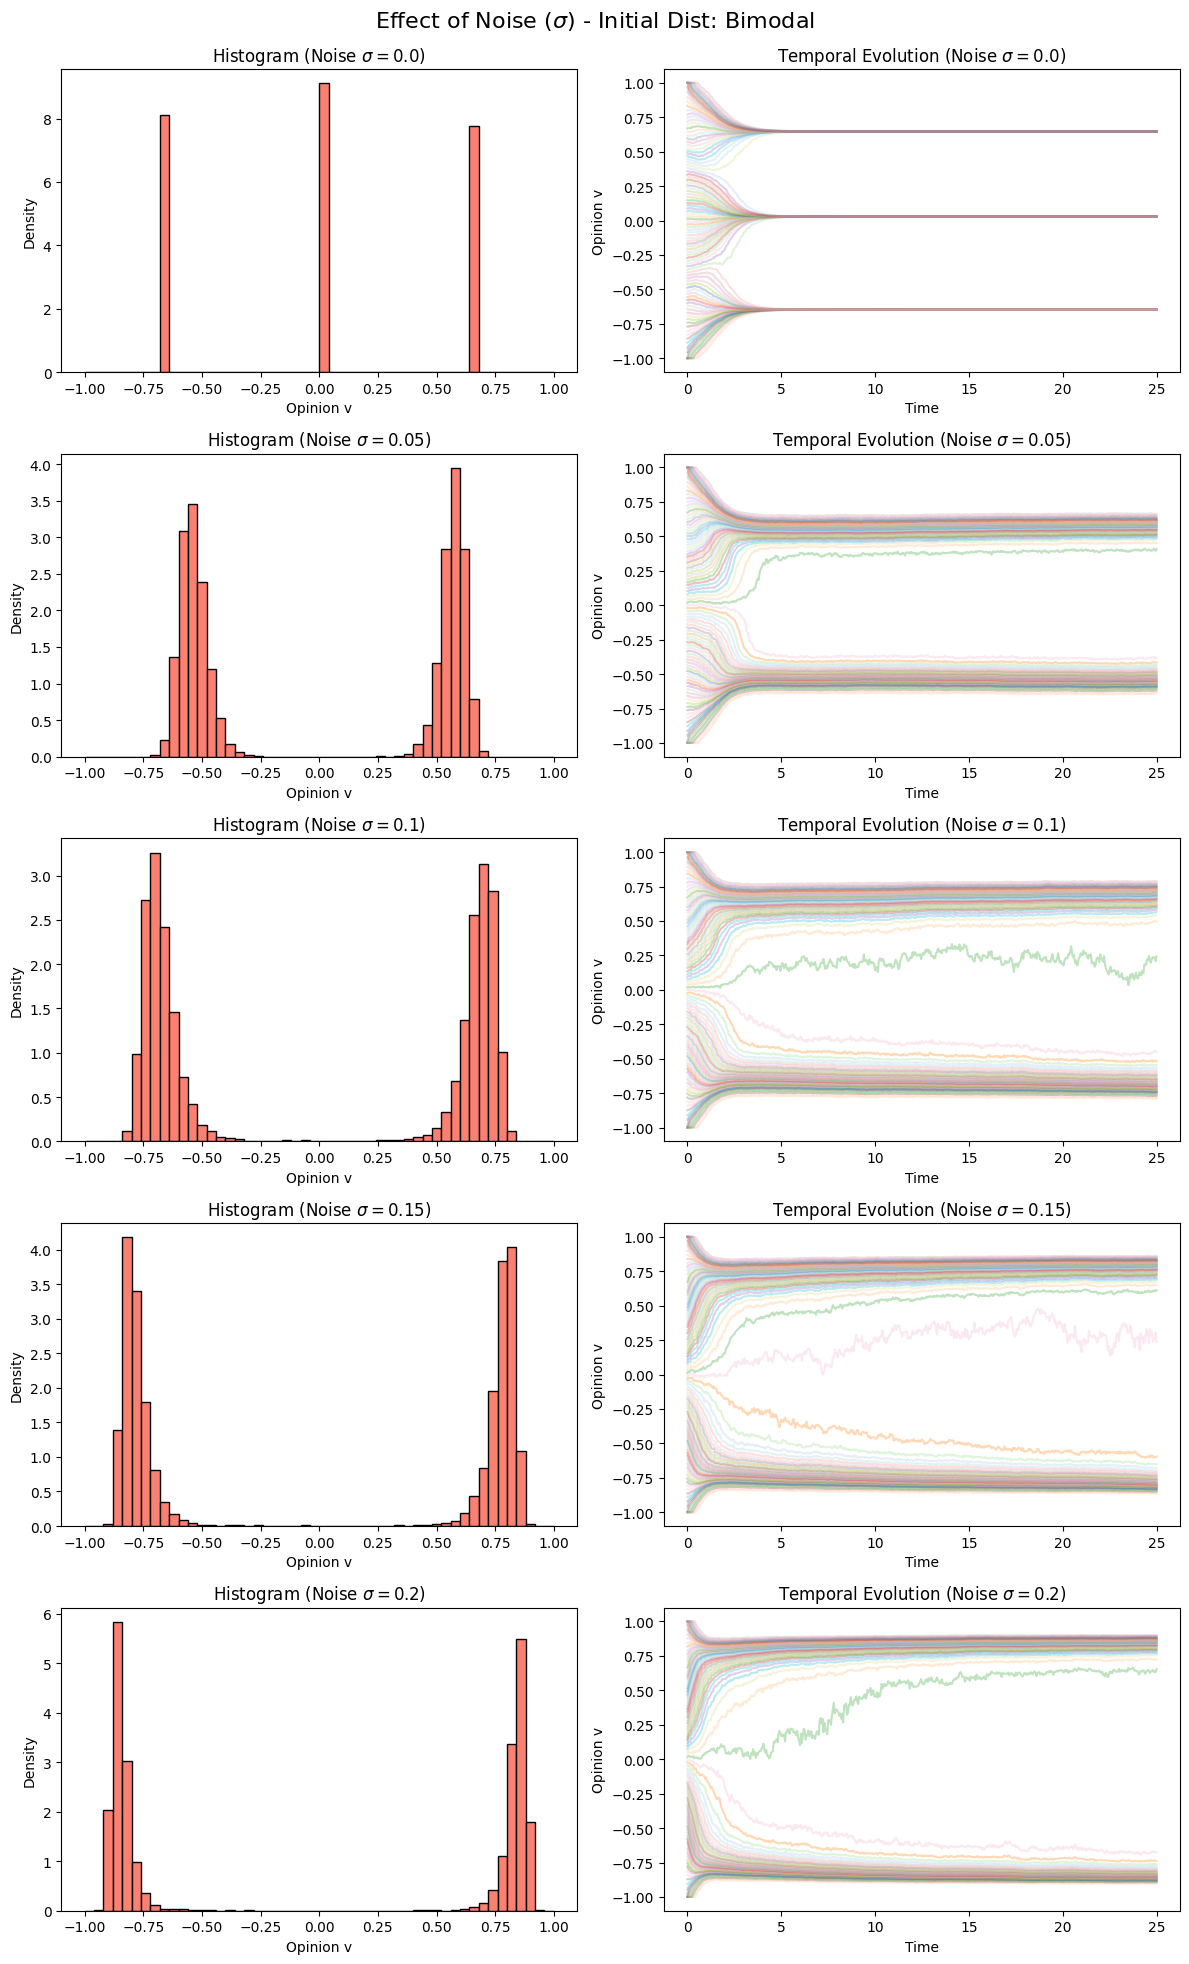

In [6]:
# Second experiment: Varying noise (Diffusion)

# Experimental settings
distributions = ['uniform', 'normal', 'bimodal']
sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.4 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)


# 100 lines, representing percentiles from 1% to 99%
# This visualizes the density flow rather than individual agent trajectories
quantiles = np.linspace(1, 99, 100)

# Create a color map for the quantile lines
cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5
np.random.seed(42)
np.random.shuffle(colors)


# Loop for each distribution
for dist_name in distributions:
    print(f"Running noise experiment for distribution: {dist_name}...")

    fig, axes = plt.subplots(len(sigmas), 2, figsize=(12, 4 * len(sigmas)))

    for i, s in enumerate(sigmas):
        # Run simulation with varying sigma 's' and fixed 'r'
        history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist=dist_name)
        final_opinions = history[-1]

        # Left Column: Final Histogram
        axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True, color='salmon', edgecolor='black')
        axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
        axes[i, 0].set_xlabel("Opinion v")
        axes[i, 0].set_ylabel("Density")
        axes[i, 0].set_xlim(-1.1, 1.1)

        # Right Column: Temporal Evolution (Quantiles)
        # We plot percentiles over time to visualize how the distribution splits or converges
        quantile_history = np.percentile(history, quantiles, axis=1)

        for q_idx in range(len(quantiles)):
            axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                            color=colors[q_idx], alpha=0.3, linewidth=1.5)

        axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
        axes[i, 1].set_xlabel("Time")
        axes[i, 1].set_ylabel("Opinion v")
        axes[i, 1].set_ylim(-1.1, 1.1)

    fig.suptitle(f"Effect of Noise ($\sigma$) - Initial Dist: {dist_name.capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Save figure
    filename = f"Opinions_s_{dist_name}_04.png"
    plt.savefig(filename, dpi=150)
    print(f"Saved figure: {filename}")
    plt.show()

In this second experiment, we analyze the impact of the ** noise parameter $\sigma$**. Sociologically, this term represents external influences, uncertainty in communication, or the degree of self-thinking. In this case, we fix the radius to $r = 0.1$, in order to see how noise affects a fragmented society.

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:53: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-308642011.py:35: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
/tmp/ipython-input-308642011.py:48: SyntaxWarning: invalid escape sequence '\s'
  axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
/tmp/ipython-input-308642011.py:53: SyntaxWarning: invalid escape sequence '\s'
  fig.suptitle(f"Effect of Noise ($\sigma$) - Initial Dist: {dist_name.capitalize()}", fontsize=16)


Running noise experiment for distribution: uniform...
Saved figure: Opinions_s_uniform_015.png


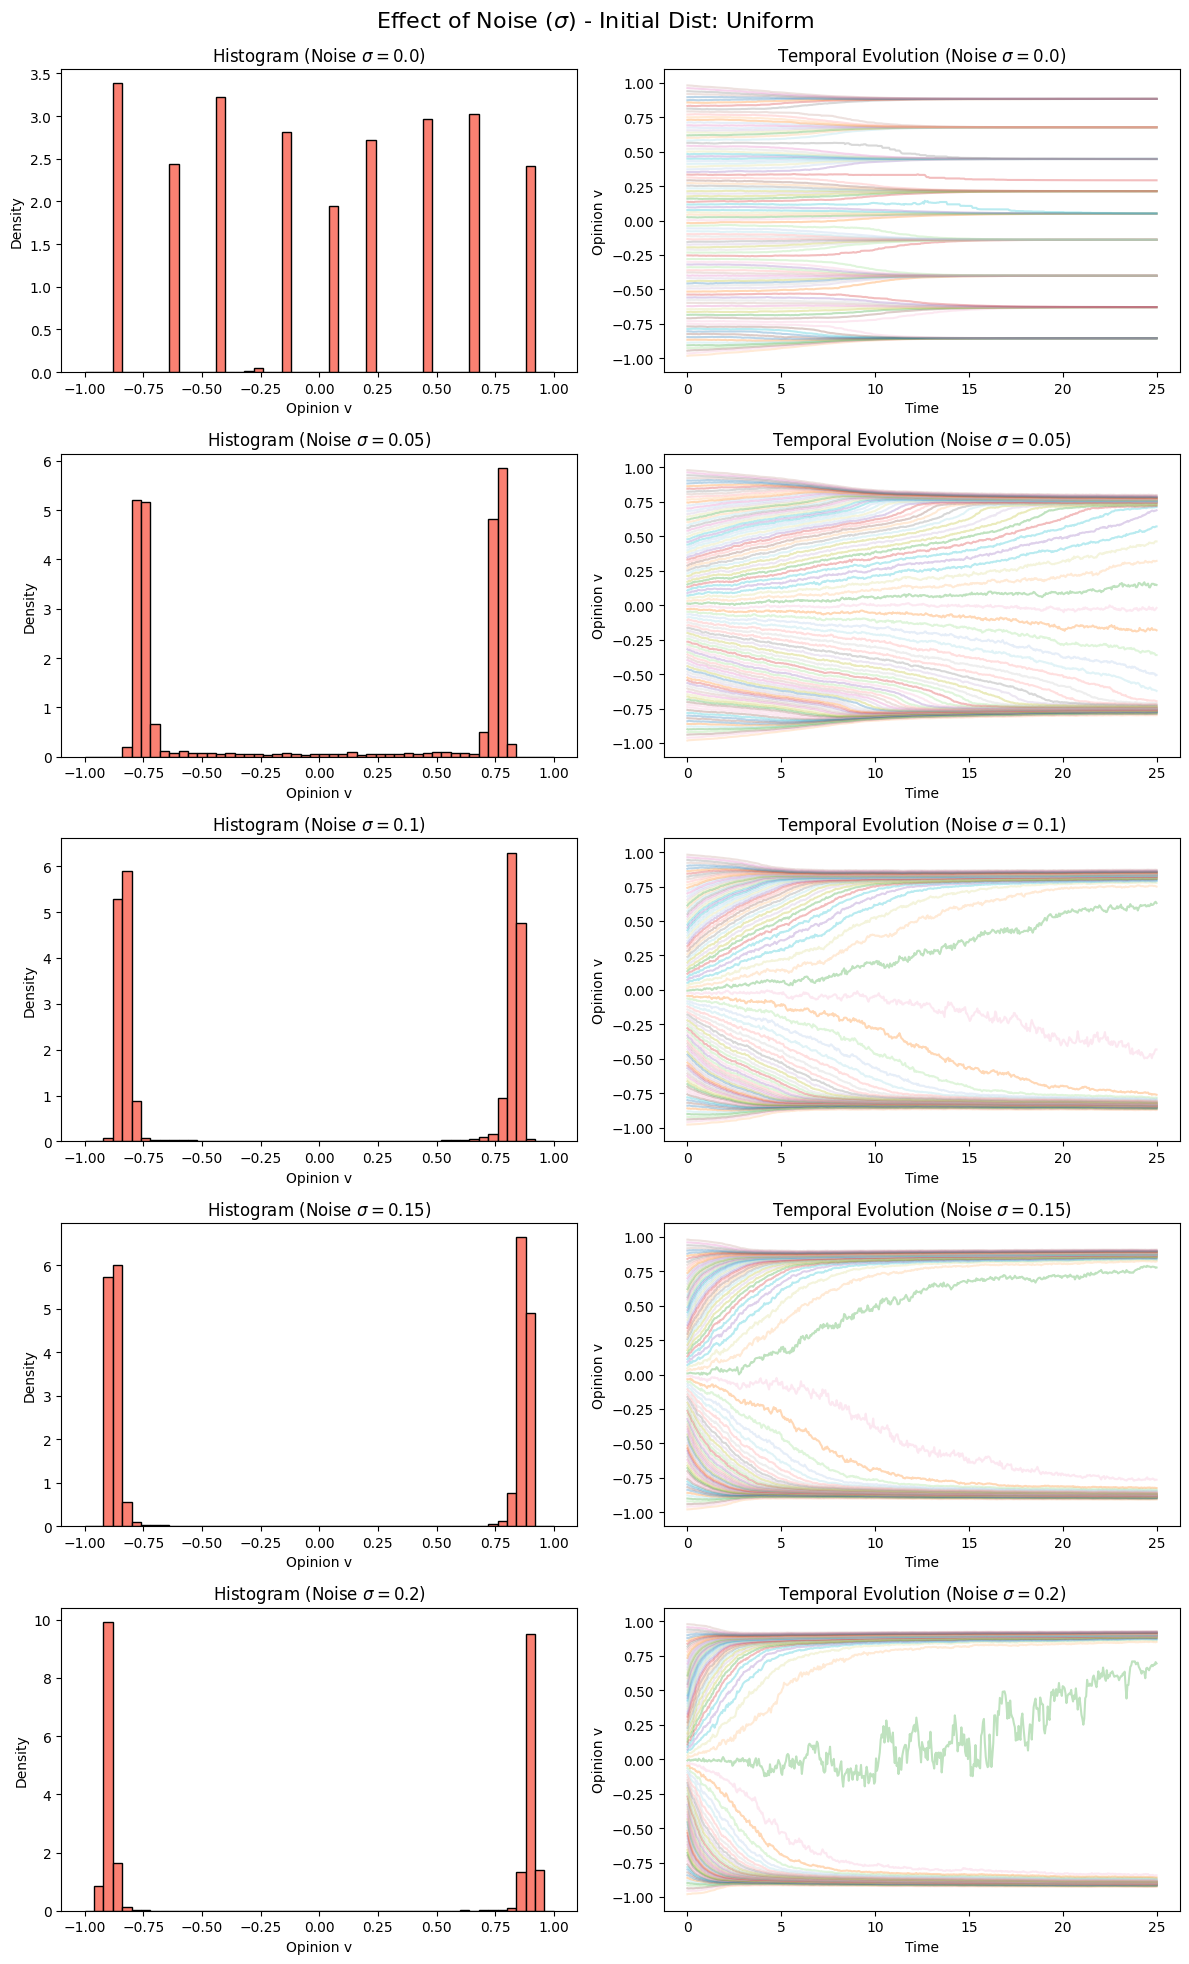

Running noise experiment for distribution: normal...
Saved figure: Opinions_s_normal_015.png


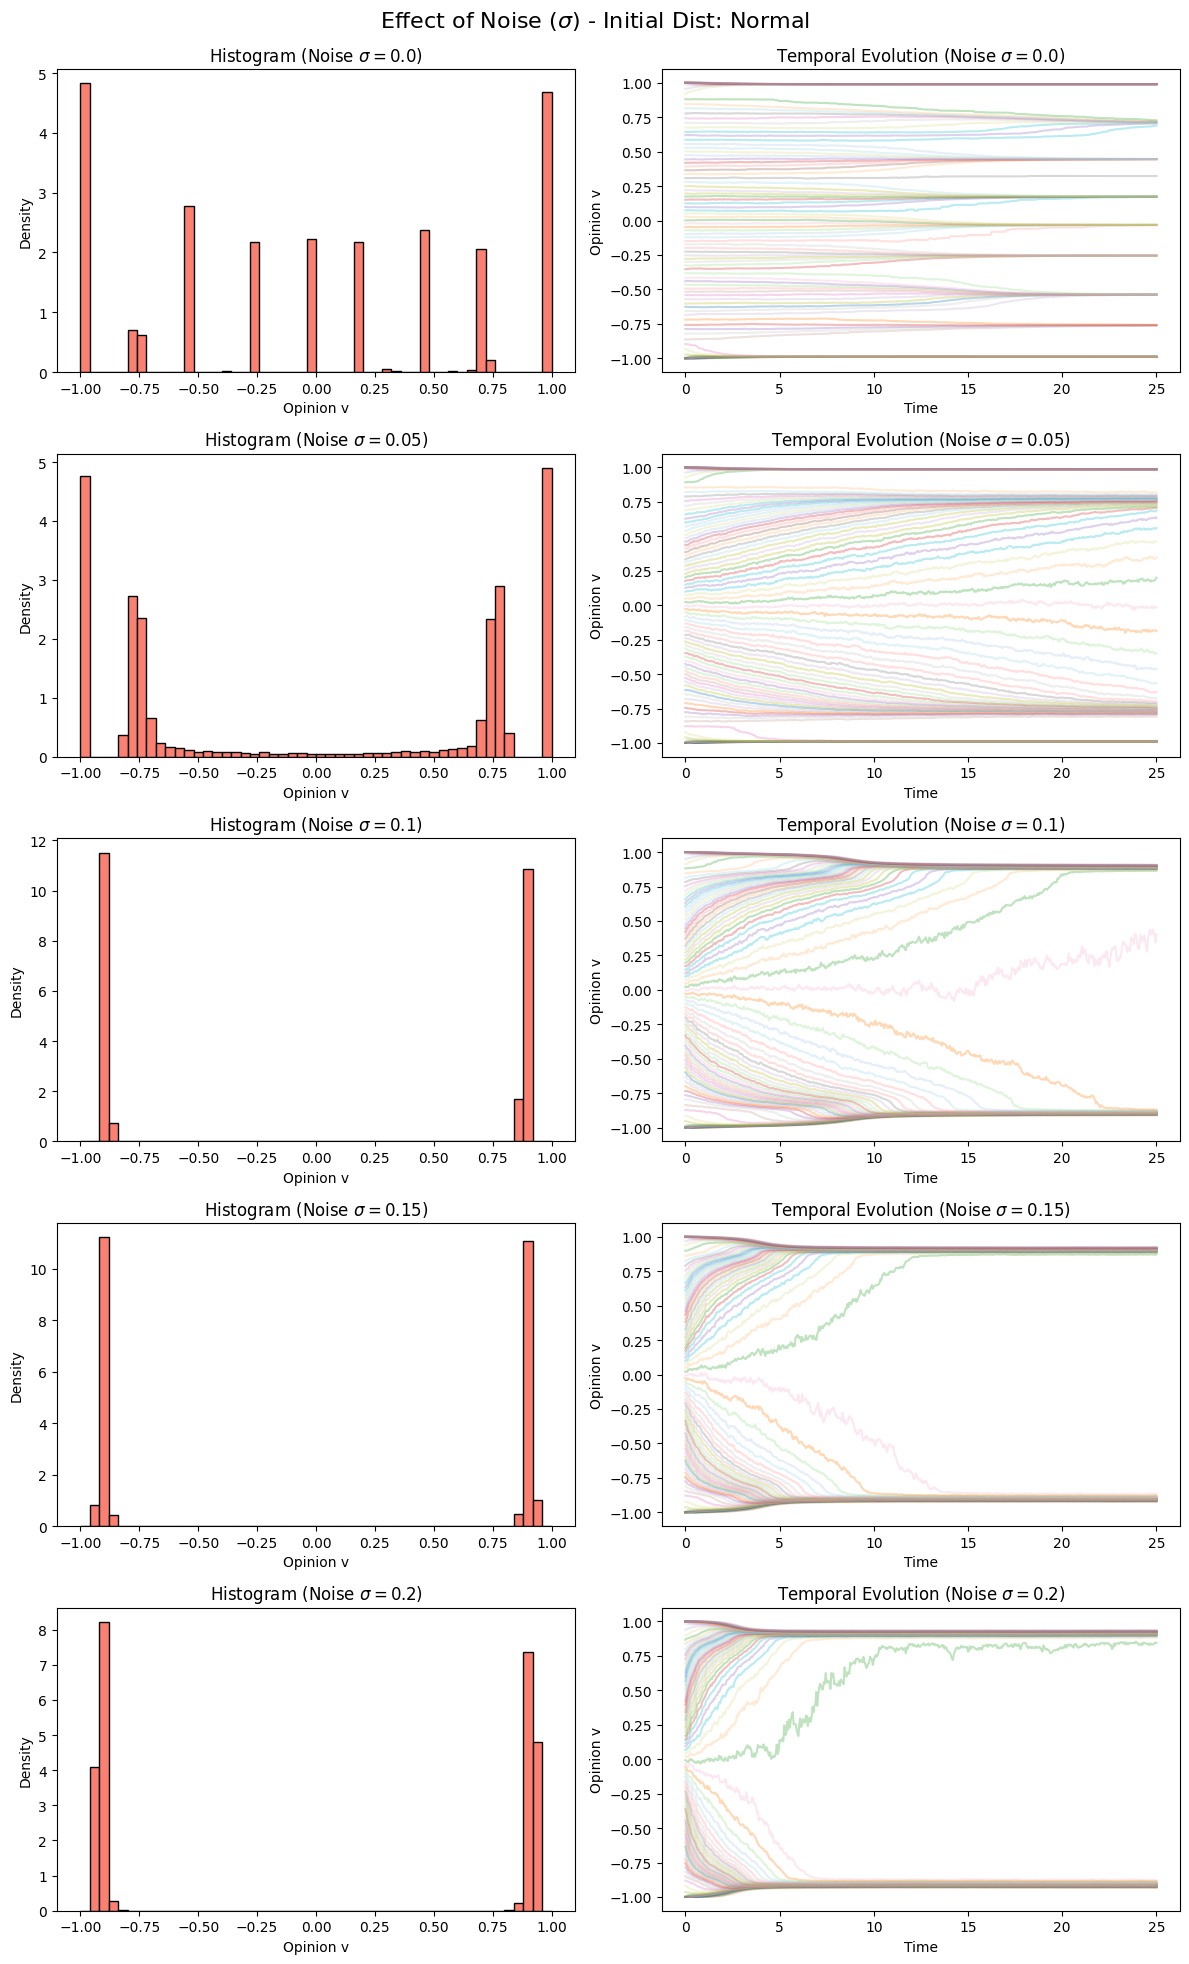

Running noise experiment for distribution: bimodal...
Saved figure: Opinions_s_bimodal_015.png


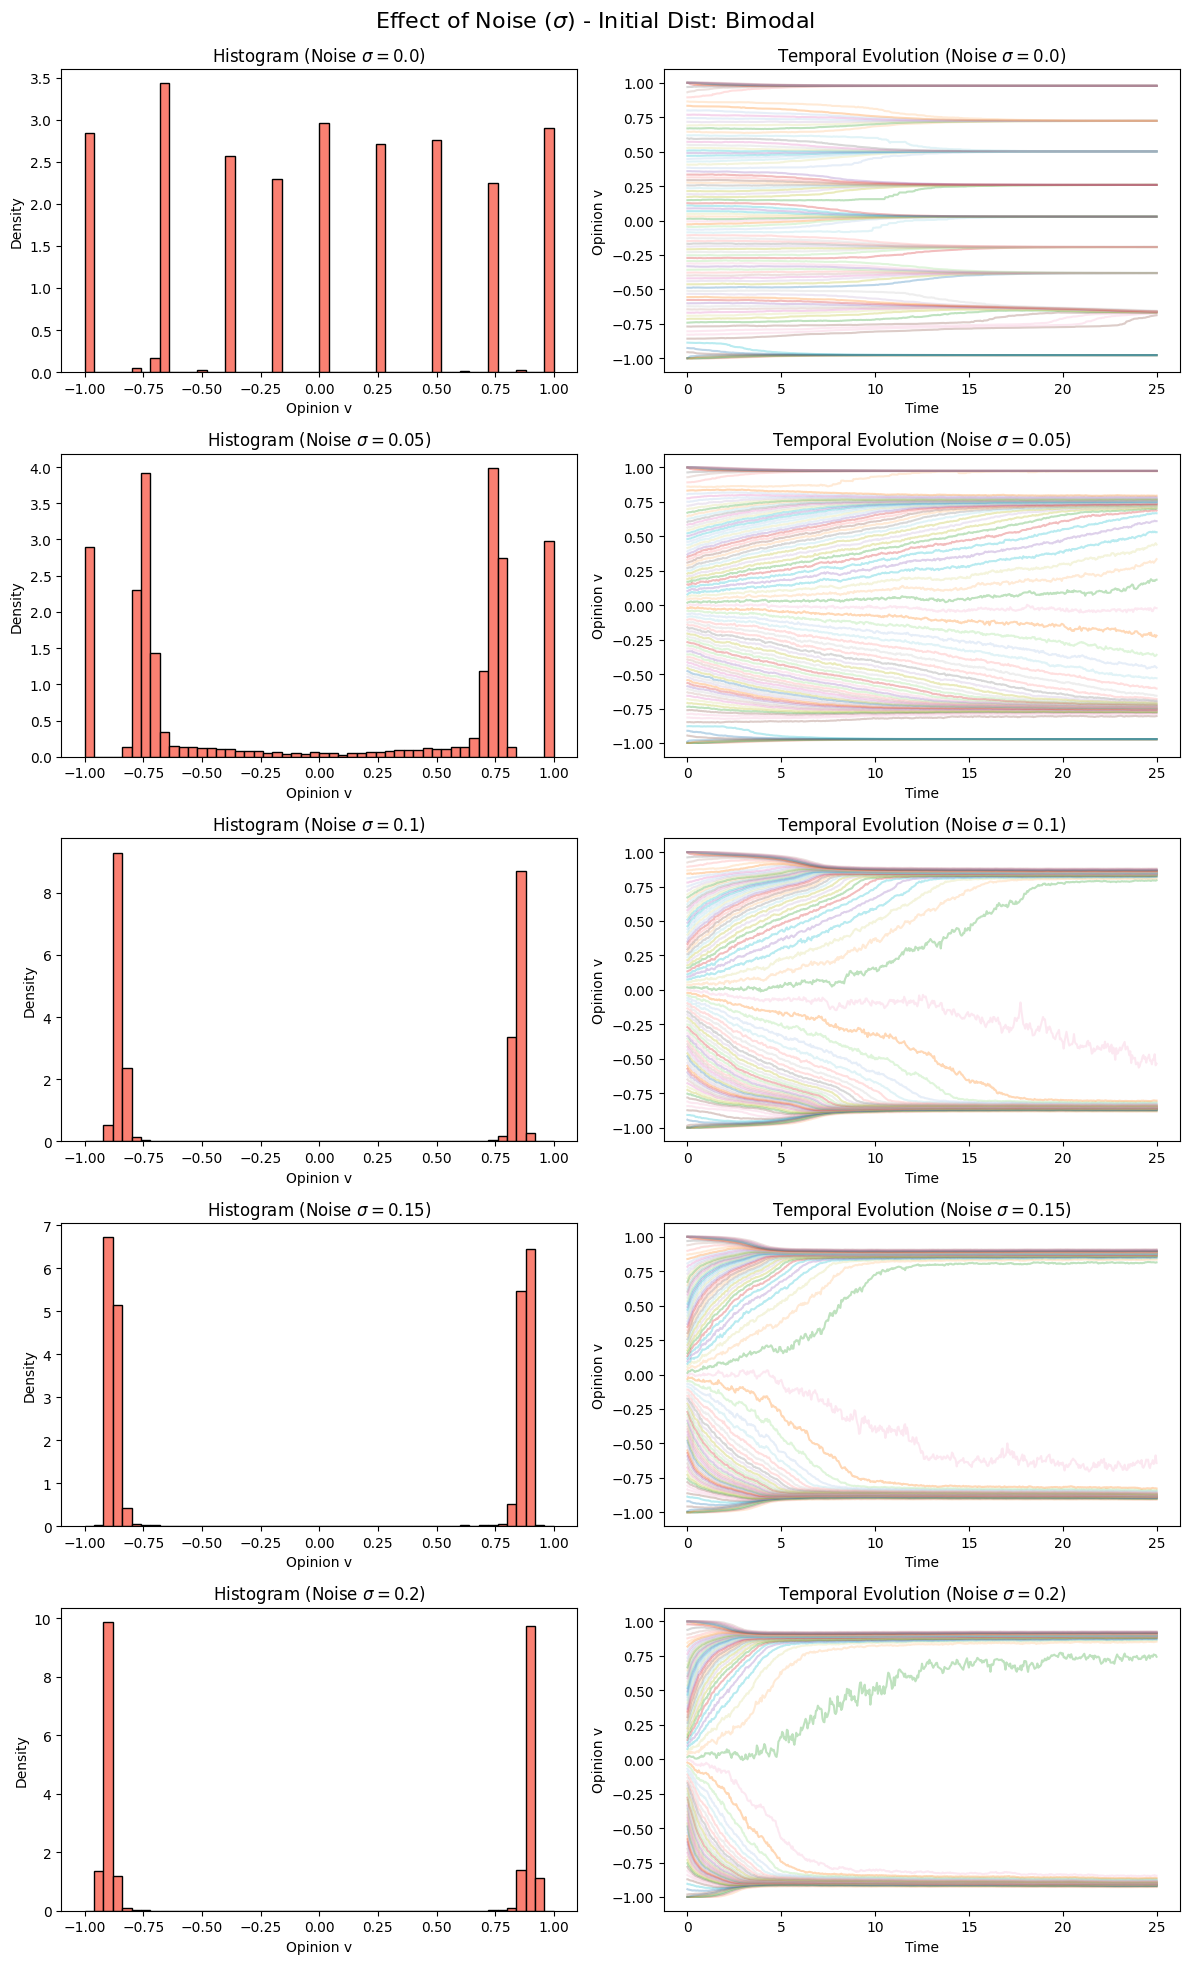

In [3]:
# Second experiment: Varying noise (Diffusion)

# Experimental settings
distributions = ['uniform', 'normal', 'bimodal']
sigmas = [0.0, 0.05, 0.1, 0.15, 0.2]
r_fixed = 0.1 # High radius to favor consensus
time_axis = np.linspace(0, T_final, n_steps + 1)


# 100 lines, representing percentiles from 1% to 99%
# This visualizes the density flow rather than individual agent trajectories
quantiles = np.linspace(1, 99, 100)

# Create a color map for the quantile lines
cmap = plt.get_cmap('tab20')
base_colors = [cmap(i) for i in np.linspace(0, 1, 20)]
colors = base_colors * 5
np.random.seed(42)
np.random.shuffle(colors)


# Loop for each distribution
for dist_name in distributions:
    print(f"Running noise experiment for distribution: {dist_name}...")

    fig, axes = plt.subplots(len(sigmas), 2, figsize=(12, 4 * len(sigmas)))

    for i, s in enumerate(sigmas):
        # Run simulation with varying sigma 's' and fixed 'r'
        history = simulation_opinion(N, n_steps, dt, gamma, s, r_fixed, alphav, init_dist=dist_name)
        final_opinions = history[-1]

        # Left Column: Final Histogram
        axes[i, 0].hist(final_opinions, bins=50, range=(-1, 1), density=True, color='salmon', edgecolor='black')
        axes[i, 0].set_title(f"Histogram (Noise $\sigma={s}$)")
        axes[i, 0].set_xlabel("Opinion v")
        axes[i, 0].set_ylabel("Density")
        axes[i, 0].set_xlim(-1.1, 1.1)

        # Right Column: Temporal Evolution (Quantiles)
        # We plot percentiles over time to visualize how the distribution splits or converges
        quantile_history = np.percentile(history, quantiles, axis=1)

        for q_idx in range(len(quantiles)):
            axes[i, 1].plot(time_axis, quantile_history[q_idx, :],
                            color=colors[q_idx], alpha=0.3, linewidth=1.5)

        axes[i, 1].set_title(f"Temporal Evolution (Noise $\sigma={s}$)")
        axes[i, 1].set_xlabel("Time")
        axes[i, 1].set_ylabel("Opinion v")
        axes[i, 1].set_ylim(-1.1, 1.1)

    fig.suptitle(f"Effect of Noise ($\sigma$) - Initial Dist: {dist_name.capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Save figure
    filename = f"Opinions_s_{dist_name}_015.png"
    plt.savefig(filename, dpi=150)
    print(f"Saved figure: {filename}")
    plt.show()





This experiment is not in the thesis; however, is the next logical step in the numerical analysis.

In this final experiment, we visualize the "phase diagram" of the society. We systematically vary two control parameters:
1.  **Confidence Radius or Bounded Confidence ($r$)**
2.  **Noise Intensity ($\sigma$)**

**For each point (i,j) of the grid we compute the variance of opinions in the final time.**

The heatmaps below show the critical boundaries where the society transitions from a polarized state to a consensus state.

<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:36: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2804719678.py:36: SyntaxWarning: invalid escape sequence '\s'
  axes[k].set_ylabel("Noise Intensity ($\sigma$)")


Calculating for: uniform...
Calculating for: normal...
Calculating for: bimodal...


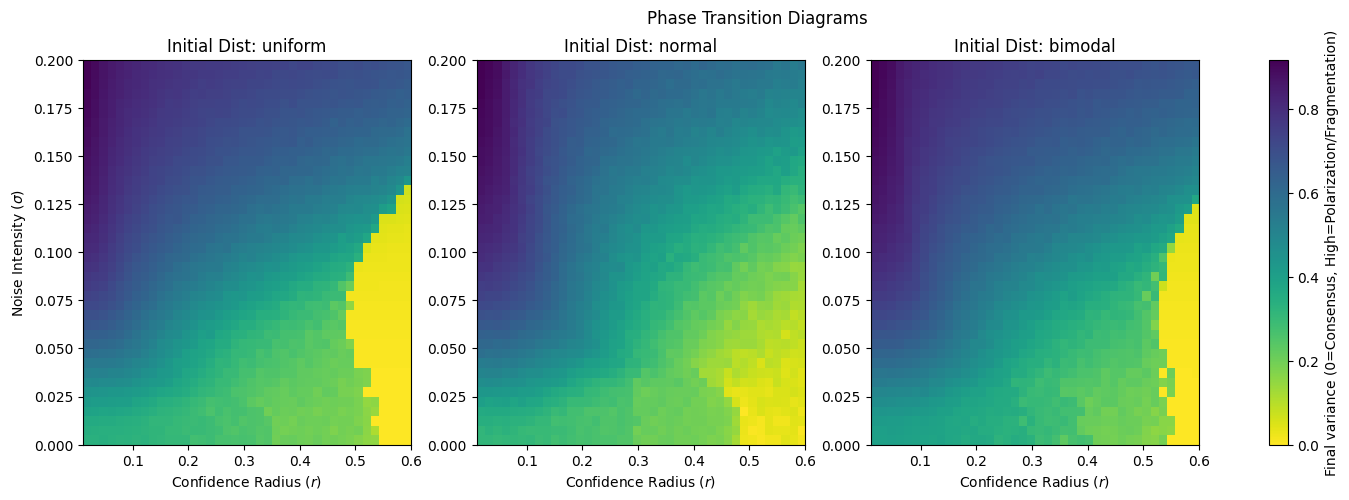

In [11]:
# 2. Phase transition Heatmap (Polarization/Fragmentation vs Consensus) for 3 Distributions

# Defining the range of parameters
r_values = np.linspace(0.01, 0.6, 40)    # Radius threshold
sigma_values = np.linspace(0.0, 0.2, 40) # Noise

distributions = ['uniform', 'normal', 'bimodal']

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for k, dist_name in enumerate(distributions):
    print(f"Calculating for: {dist_name}...")

    # Matrix to store the final results
    phase_matrix = np.zeros((len(sigma_values), len(r_values)))

    for i, s in enumerate(sigma_values):
        for j, r in enumerate(r_values):
            # Run simulation
            v_final = simulation_opinion(N, n_steps, dt, gamma, s, r, alphav, init_dist=dist_name)

            # Get final opinions (last row of history)
            final_state = v_final[-1]

            # Calculate variance
            phase_matrix[i, j] = np.var(final_state)

    # Plot Heatmap
    im = axes[k].imshow(phase_matrix, origin='lower', aspect='auto', cmap='viridis_r',
                        extent=[r_values.min(), r_values.max(), sigma_values.min(), sigma_values.max()])

    axes[k].set_title(f"Initial Dist: {dist_name}")
    axes[k].set_xlabel("Confidence Radius ($r$)")
    if k == 0:
        axes[k].set_ylabel("Noise Intensity ($\sigma$)")

fig.colorbar(im, ax=axes.ravel().tolist(), label="Final variance (0=Consensus, High=Polarization/Fragmentation)")
plt.suptitle("Phase Transition Diagrams")
plt.savefig("Opinions_Heatmap_All.png")
plt.show()